In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix,bmat
import xgboost as xgb
import itertools, gc, pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [42]:
cols = ['tourn_num','Cat','Distance_from_hole','Strokes_from_starting_location',
        'Course_#','Hole','Player_#','skill_estimate_percentile','not_seen','observation_count_percentile']\
       + ['Green_to_work_with_%d' % (slack,) for slack in range(8,23,2)]
data = pd.concat([pd.read_csv('../data/%d.csv.gz' % year,usecols=cols) for year in range(2003,2011)])

In [43]:
data.not_seen = data.not_seen.astype(float)
data.Strokes_from_starting_location = data.Strokes_from_starting_location.astype(float)
data.skill_estimate_percentile = data.skill_estimate_percentile.fillna(.5)
data.observation_count_percentile = data.observation_count_percentile.fillna(.5)

In [52]:
def prepare_data(cat,num_tourns,slack,with_skill_estimates,with_player_num,with_course_hole):
    num_tournaments = len(pd.unique(data.tourn_num))
    trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
    tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
    sub = data[data.Cat.isin(cat_map[cat])].reset_index(drop=True)
    trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
    tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
    cols = ['Distance_from_hole']
    if cat!='Green': cols += ['Green_to_work_with_%d' % (slack,)]
    if with_skill_estimates: cols += ['skill_estimate_percentile','not_seen','observation_count_percentile']
    X = sub[cols].values
    y = sub.Strokes_from_starting_location.values
    if with_course_hole:
        course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
        course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
                                        for tup in sub[['Course_#','Hole']].values])
    else:
        course_strings, course_hole_strings = [], []
    if with_player_num:
        player_strings = np.array(['%d' % (num,) for num in sub['Player_#']])
    else:
        player_strings = []
    return X,y,course_strings,course_hole_strings,player_strings,trains,tests

In [53]:
# def psuedo_huber(preds, dtrain):
#     labels = dtrain.get_label()
#     delta = psuedo_huber.delta
#     resids = preds - labels
#     grad = resids * (1 + (resids/delta)**2)**(-.5)
#     hess = (1 + (resids/delta)**2)**(-1.5)
#     return grad, hess

def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

cats = ['Green','Fairway','Rough','Other','Bunker','Tee Box']
cat_map = {'Green':set(['Green']),'Fairway':set(['Fringe','Fairway']),'Bunker':set(['Bunker']),
           'Rough':set(['Primary Rough','Intermediate Rough']),'Other':set(['Other']),'Tee Box':set(['Tee Box'])}
delta_map = {'Green':.6,'Fairway':.9,'Rough':1.05,'Other':1.5,'Bunker':1.05,'Tee Box':1.25}
params = {'objective':'reg:linear','min_child_weight':4,
          'subsample':.75,'tree_method':'approx','silent':1,
          'eta':.05,'lambda':15,'max_depth':9}

def run(cat,num_tourns,slack,with_skill_estimates,with_player_num,with_course_hole,params,eval_pct):
    (X,y,course_strings,course_hole_strings,player_strings,trains,tests) = prepare_data(cat,num_tourns,slack,
                                                                                        with_skill_estimates,
                                                                                        with_player_num,
                                                                                        with_course_hole)
    #psuedo_huber.delta = delta_map[cat]
    if with_course_hole:
        X = csc_matrix(X)
    results = []
    for u,(train,test) in enumerate(zip(trains,tests)):
        gc.collect()
        if with_course_hole or with_player_num:
            X_train, X_test = X.copy()[train], X.copy()[test]
        else:
            X_train, X_test = np.copy(X)[train], np.copy(X)[test]
        if with_player_num:
            lb3 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb3.fit_transform(player_strings[train])]],format='csc')
            X_test = bmat([[X_test,lb3.transform(player_strings[test])]],format='csc')
        if with_course_hole:
            lb1 = LabelBinarizer(sparse_output=True)
            lb2 = LabelBinarizer(sparse_output=True)
            X_train = bmat([[X_train,lb1.fit_transform(course_strings[train]),
                             lb2.fit_transform(course_hole_strings[train])]],format='csc')
            X_test = bmat([[X_test,lb1.transform(course_strings[test]),
                            lb2.transform(course_hole_strings[test])]],format='csc')
        
        if u%8==0:
            #print 'finding_num_trees'
            num_trees = find_num_trees(X_train,y[train],params,eval_pct)
        dtrain = xgb.DMatrix(X_train,label=y[train])
        dtest = xgb.DMatrix(X_test)
        params['base_score'] = y[train].mean()
        bst = xgb.train(params,dtrain,num_trees)
        preds = bst.predict(dtest)
        error = np.mean((preds-y[test])**2)
        mean_error = np.mean((np.mean(y[train])-y[test])**2)
        r_sq = (mean_error-error)/mean_error
        #print len(test),num_trees,r_sq
        results.append(r_sq)
    mean, std_err = np.mean(results), np.std(results)/num_tourns**.5
    return (mean-std_err,mean+std_err)

In [26]:
results = {}
for cat in cats[1:]:
    for slack in range(8,23,2):
        print cat,slack
        res = run(cat,15,slack,False,params,.22)
        print res
        results[(cat,slack)] = res

Fairway 8
(0.33928774074220902, 0.36694465693894163)
Fairway 10
(0.33939533077447553, 0.36708214590545502)
Fairway 12
(0.33949765709202639, 0.36720138080988662)
Fairway 14
(0.33936518256020809, 0.36713107857507121)
Fairway 16
(0.33943184493827866, 0.36717784905189216)
Fairway 18
(0.33942500325098279, 0.36720861093109103)
Fairway 20
(0.33946587097051889, 0.36723312783401069)
Fairway 22
(0.33945275122255131, 0.36724072256257884)
Rough 8
(0.36590330290437384, 0.39803482771916371)
Rough 10
(0.36661282884573582, 0.39869305580604214)
Rough 12
(0.36690523250219581, 0.39897309237973372)
Rough 14
(0.36691572614204454, 0.39907423387977498)
Rough 16
(0.36722057732378061, 0.39933902312079755)
Rough 18
(0.36757315530789747, 0.39966912048755843)
Rough 20
(0.36795846857652453, 0.39996129556093413)
Rough 22
(0.36755091229368408, 0.39963042594380638)
Other 8
(0.16378576879057768, 0.22738587129704643)
Other 10
(0.16331782924313584, 0.22843607481311659)
Other 12
(0.16601417763369203, 0.2267626239484446)


Fairway


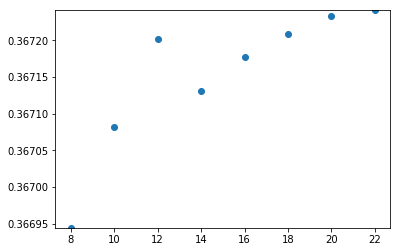

Rough


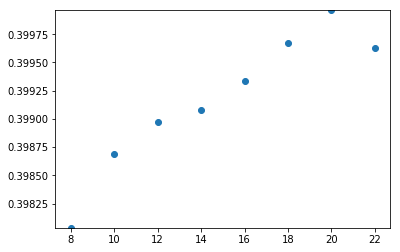

Other


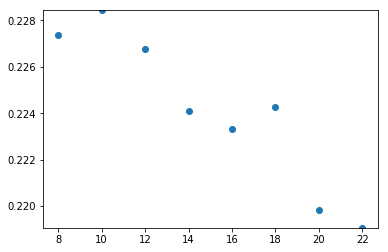

Bunker


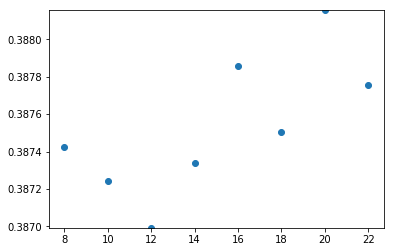

In [36]:
y_ = np.array([])
for cat in cats[1:-1]:
    print cat
    x,y = (np.array([key[1] for key in results.keys() if key[0]==cat]),
           np.array([results[key][1] for key in results.keys() if key[0]==cat]))
    plt.scatter(np.sort(x),y[np.argsort(x)]);
    plt.ylim(np.amin(y),np.amax(y))
    y_ = np.concatenate([y_,y-np.mean(y)])
    plt.show()

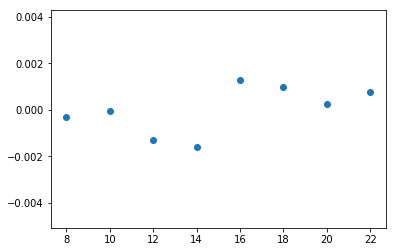

In [41]:
plt.scatter(x,y_.reshape((4,8)).mean(0))
plt.ylim(np.amin(y_),np.amax(y_));

In [ ]:
results = {}
results['Green'] = ((0.58976062042512356, 0.59642895108859784),
                    (0.59152030736690209, 0.59815610257623575))
for cat in cats:
    print cat
    if cat!='Green':
        res1 = run(cat,24,16,False,False,False,params,.22)
        print "baseline",res1
        res2 = run(cat,24,16,True,False,False,params,.22)
        print "with_skill_estimates", res2
    res3 = run(cat,24,16,True,True,False,params,.22)
    print "with_player_num",res3
    res4 = run(cat,24,16,True,True,True,params,.22)
    print "with_course_hole",res4
    if cat=='Green':
        results[cat] += (res3,res4)
        continue
    results[cat] = (res1,res2,res3,res4)

Green
with_player_num (0.59159504137265451, 0.59826035688280754)
with_course_hole (0.59181669120703784, 0.59848325462437468)
Fairway
baseline (0.34768046385633061, 0.36948141220287084)
with_skill_estimates (0.35048479092497653, 0.37204877873731679)
with_player_num (0.35096107461967002, 0.37256135154894238)
with_course_hole (0.35491417078870313, 0.37598051625005668)
Rough
baseline (0.37377596518776279, 0.39795682092687101)
with_skill_estimates (0.37588777454603051, 0.40004228028331623)
with_player_num (0.37674181463004863, 0.40092409002823592)
with_course_hole (0.3805135455544198, 0.40478533742223205)
Other
baseline (0.19217943924591702, 0.23655145737596001)
with_skill_estimates (0.19014789138648205, 0.23273227050468995)
with_player_num (0.19098039628998698, 0.23506506111918996)
with_course_hole (0.21966720141308127, 0.27853850998750845)
Bunker
baseline (0.33246257738623008, 0.36104044325785134)
with_skill_estimates (0.336210867839289, 0.36494965876821894)
with_player_num (0.33802032009